In [6]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 7.3 MB/s 
     |████████████████████████████████| 58 kB 8.0 MB/s 
     |████████████████████████████████| 376 kB 63.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=fb30e525434965d3efa21a02a018c94885aa5026661d507ba91e3482ddb55ef0
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=0460e09f40b948e4471fe5bb49e3bc4361b66b64a4ece911586c0329281ae4d6
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# **Download Dataset**


In [7]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 42.98 MiB/s, done.
Resolving deltas: 100% (3/3), done.


# **Some common import**

In [8]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [21]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

![Untitled Diagram.drawio (2).png](Ã¢ÂÂ¦NiWmUQMAgYBAwCBgGDgEHAIGAQMAgYBNY8Ai5Dttb8GJkGGgQMAgYBg4BBwCBgEDAIGAQMAucgAv8/IbsD7n49eDYAAAAASUVORK5CYII=)

# **Task 2: Setup Configuration**

In [10]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.004

IMAGE_SIZE = 320

ENCODER = 'timm-efficientnet-b0'
WEIGHT = 'imagenet'

In [11]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [12]:
row = df.iloc[4]

image_path = row['images'] 
mask_path = row['masks']

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

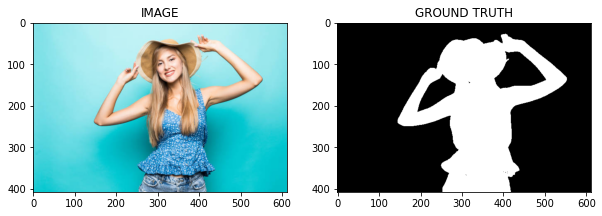

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [14]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# **Data Augumentation**

+ Albumentations là một thư viện Python để tăng cường hình ảnh. Nâng cao hình ảnh được sử dụng trong các nhiệm vụ học tập sâu và thị giác máy tính để tăng chất lượng của các mô hình được đào tạo. Mục đích của nâng cao hình ảnh là tạo ra các mẫu đào tạo mới từ dữ liệu hiện có.
+ Simple example:
```
import albumentations as A
import cv2
# Declare an augmentation pipeline
transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])
# Read an image with OpenCV and convert it to the RGB colorspace
image = cv2.imread("image.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Augment an image
transformed = transform(image=image)
transformed_image = transformed["image"]
```

In [15]:
import albumentations as A

def get_train_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE,IMAGE_SIZE),
                    A.HorizontalFlip(p = 0.5),
                    A.VerticalFlip(p = 0.5),
  ])

def get_valid_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE,IMAGE_SIZE),
                    
  ])


# **Create Custom Datasets**

In [16]:
from torch.utils.data import Dataset

In [17]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # (h, w,c)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask= mask)
      image = data['image']
      mask = data['mask']

    # (h, w, c) -> (c, h, w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [18]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [19]:
print(f"Size of Trainset: {len(trainset)}")
print(f"Size of Validset: {len(validset)}")

Size of Trainset: 232
Size of Validset: 58


In [24]:
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py

--2022-08-26 13:32:10--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2022-08-26 13:32:10 (27.9 MB/s) - ‘helper.py’ saved [2813/2813]



In [26]:
def imshow(image, ax=None, title=None, normalize=True):
  """Imshow for Tensor."""
  if ax is None:
      fig, ax = plt.subplots()
  image = image.numpy().transpose((1, 2, 0))

  if normalize:
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      image = std * image + mean
      image = np.clip(image, 0, 1)

  ax.imshow(image)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.tick_params(axis='both', length=0)
  ax.set_xticklabels('')
  ax.set_yticklabels('')

  return ax

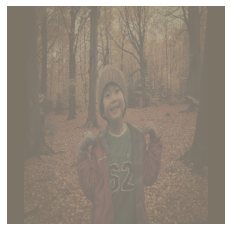

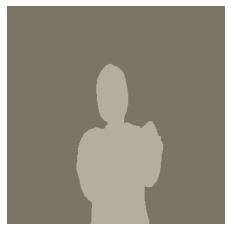

In [31]:
import helper
idx = 21
image, mask = trainset[idx]
imshow(image)
imshow(mask)

# **Load dataset into batches**

In [33]:
from torch.utils.data import DataLoader
BATCH_SIZE = 16

In [34]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle=True) 
validloader = DataLoader(validset, batch_size= BATCH_SIZE)

In [35]:
print(f"Total no. of batches in trainloader: {len(trainloader)}")
print(f"Total no. of batches in validloader: {len(validloader)}")

Total no. of batches in trainloader: 15
Total no. of batches in validloader: 4


In [36]:
for image, mask in trainloader:
  break
print(f"One of batch image shape: {image.shape}")
print(f"One of batch mask shape: {mask.shape}")

One of batch image shape: torch.Size([16, 3, 320, 320])
One of batch mask shape: torch.Size([16, 1, 320, 320])


# **Create Segmentation Model**

+ segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

> Indented block



In [37]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [38]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHT,
        in_channels=3,
        classes=1,
        activation= None
    )
  
  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

# **Create Train and Validation Function**

In [42]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in data_loader:
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)

    loss.backward()
    optimizer.step()
    
    total_loss += loss.item()
  return total_loss / len(data_loader)



In [43]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in data_loader:
      
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()
  
  return total_loss / len(data_loader)



# **Train Model**

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [47]:
best_valid_loss = np.Inf
for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss
  
  if i % 5 == 0:
    print(f"Epoch: {i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}")

SAVED-MODEL
Epoch: 1 Train_loss: 0.1253607874115308 Valid_loss: 0.1825842671096325
SAVED-MODEL
SAVED-MODEL
Epoch: 6 Train_loss: 0.08377081255118052 Valid_loss: 0.15373609401285648
Epoch: 11 Train_loss: 0.2324909766515096 Valid_loss: 0.44029979407787323
Epoch: 16 Train_loss: 0.09455022911230723 Valid_loss: 0.17914988659322262
Epoch: 21 Train_loss: 0.07104700803756714 Valid_loss: 0.1763342283666134


# **Inference**

In [49]:
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)

pred_mask = torch.sigmoid(logits_mask)

pred_mask = (pred_mask > 0.5) * 1.0



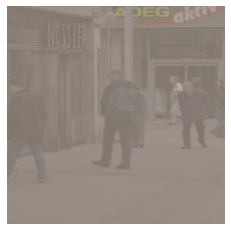

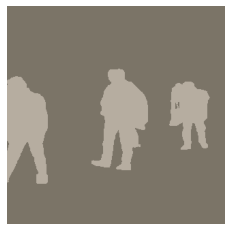

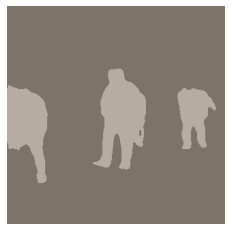

In [51]:
imshow(image)
imshow(mask)
imshow(pred_mask.detach().cpu().squeeze(0))